# Geospatial ML - Random distributed points, a mining example

This tutorial was written originally by Thomas Ostersen and Tom Carmichael of [Datarock](https://datarock.com.au/) for Transform 2022 conference. I thank them for putting togther this tutorial and sharing it, under an open license. Please give all kudos to them :) 

### Changes and Spirit

Small changes will be done shorten and lightly edit where I see fit. Some addtional analysis will also be added. If you are interested in the original work, please check out the repo below. The science and findings should be extremely similar as the original work. 

### Orignal Repo

is [here](https://github.com/Solve-Geosolutions/transform_2022)

### Original Data License

All data presented in this tutorial were derived from open data sets made available through [Mineral Resources Tasmania](https://www.mrt.tas.gov.au/) and [Geoscience Australia](https://www.ga.gov.au/).

**LICENSE CONDITIONS**

By exporting this data you accept and comply with the terms and conditions set out below:

[Creative Commons Attribution 3.0 Australia](https://creativecommons.org/licenses/by/3.0/au/)

<img src="assets/creative_commons_logo.png" />

# Why This Mining Geology Example?

This is a great example of how we need to account for [spatial autocorrelation](https://www.paulamoraga.com/book-spatial/spatial-autocorrelation.html#) (another reference [here](https://mgimond.github.io/Spatial/spatial-autocorrelation.html)) for machine learning projects. Rocks generally (but not always!) are not time dependent. I would not necessairly use the same methods for time dependent weather/climate datasets. 

# Geologic Background:

## Study Area: Northeastern Tasmania

* Oldest rocks belong to thick package of folded Ordovician Mathinna Supergroup sediments
* These extensively intruded by granitoids in the Devonian
* Study area is prospective for intrusion related tin-tungsten and gold mineralisation

<img src="assets/hong_et_al_2019_tasgeomap.png" style="width: 800px" />

<center>Figure modifed from <a href=https://doi.org/10.2138/am-2019-6534>Hong et al, (2019)</a></center>

## Download Data Sets

  1. Download the zipped data set from our thredds server
  2. Unzip the data directory 
  

In [1]:
import requests
import zipfile
from io import BytesIO
import os

In [2]:
def download_and_unzip(url, extract_to='geodata'):
    """
    Downloads a zip file from the provided URL and extracts it to the specified folder.
    Overwrites existing files in the target directory without prompting.
    """
    print(f"Downloading and extracting from {url}...")
    
    # Check if directory exists and notify
    if os.path.exists(extract_to):
        print(f"Folder '{extract_to}' already exists. Files will be overwritten.")
    
    # Create the directory if it doesn't exist
    os.makedirs(extract_to, exist_ok=True)
    
    response = requests.get(url)
    if response.status_code == 200:
        z = zipfile.ZipFile(BytesIO(response.content))
        z.extractall(extract_to)
        print(f"Successfully extracted {len(z.namelist())} files to {extract_to}/")
        return z.namelist()
    else:
        print(f"Download failed with status code: {response.status_code}")

In [3]:
files = download_and_unzip("https://thredds-test.unidata.ucar.edu/thredds/fileServer/casestudies/ml_case_study_data/tas_sn_w_datasets.zip")

Folder 'geodata' already exists. Files will be overwritten.
Successfully extracted 8 files to geodata/


## Roadmap

  1. Load and inspect data sets
      - mineral occurence point data sets with *geopandas*
      - gravity, magnetic and radiometric data sets with *rasterio*
  1. Combine data sets to build a labeled N<sub>pixel</sub>, N<sub>layers</sub> array for model training
      - inspect differences between proximal vs. distal to mineralisation pixels      
  1. Train a random forest classifier and apply to all pixels, visualise results
      - evaluate performance with a randomly selected testing subset
      - repeat with stratified classes      
  1. Develop a checkerboard data selection procedure, train and evaluate models
      - discuss effects of spatially separated testing data      
  1. Investigate occurence holdout models with a spatially clustered approach
 
---

You might need to add these two packages to your enviroment:

In [4]:
# Import key packages
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import rasterio
from rasterio.features import rasterize
# Machine learning packages
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc
from sklearn.cluster import KMeans

from scipy.interpolate import griddata

from tqdm.notebook import tqdm, trange

In [5]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import f1_score, jaccard_score, precision_score, recall_score
from tqdm.notebook import tqdm, trange
from torch.utils.data.distributed import DistributedSampler
from torch.multiprocessing import set_start_method
try:
    set_start_method('spawn')
except RuntimeError:
    pass

In [6]:
# set some plotting parameters 
mpl.rcParams.update({"axes.grid":True, "grid.color":"gray", "grid.linestyle":'--','figure.figsize':(10,10)})

## Pointing to our data directory

In [7]:
data_dir = 'geodata/'

# set path to minoccs
point_fn = os.path.join(data_dir, 'sn_w_minoccs.gpkg')

# make a list of rasters in the data directory
geotiffs = [os.path.join(data_dir, x) for x in os.listdir(data_dir) if '.tif' in x]
point_fn, geotiffs

('geodata/sn_w_minoccs.gpkg',
 ['geodata/tasrad_K_pct.tif',
  'geodata/tasmag_TMI.tif',
  'geodata/tasrad_Th_ppm.tif',
  'geodata/tasgrav_IR.tif',
  'geodata/tasmag_TMI_1VD.tif',
  'geodata/tasrad_U_ppm.tif',
  'geodata/tasgrav_IR_1VD.tif'])

First cut at plotting, where do we have occurances

<Axes: >

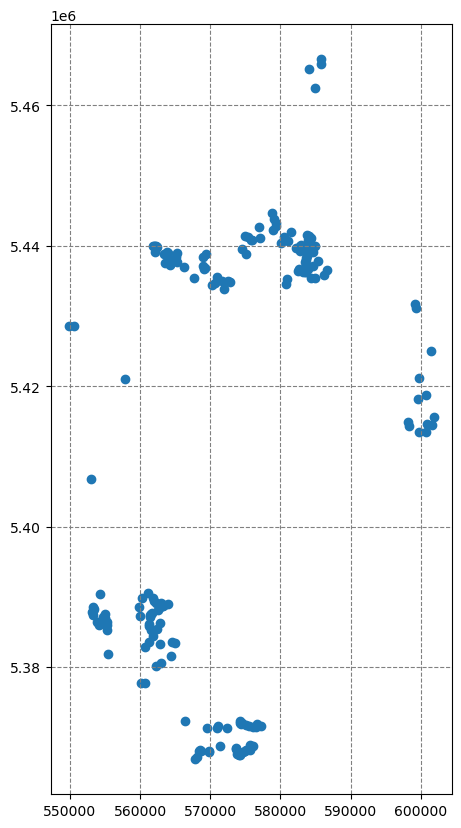

In [8]:
df = gpd.read_file(point_fn)
df.plot()

### Reading in GeoTiffs

In [9]:
# read geotiffs
data, names = [], []  # Lists to store data and corresponding file names
for fn in geotiffs:  # Loop through each GeoTIFF file
    with rasterio.open(fn, 'r') as src:  # Open GeoTIFF file for reading
        # read spatial information
        transform = src.transform  # Get affine transformation matrix
        region = (src.bounds[0], src.bounds[2], src.bounds[1], src.bounds[3])  # Get bounding box coordinates (left, bottom, right, top)
        # read band 1 data
        d = src.read(1)  # Read data from the first band
        nodata_mask = d == src.nodata  # Create a mask for NoData values
        d[nodata_mask] = np.nan  # Replace NoData values with NaN
        # append data to lists
        data.append(d)  # Append data to the list
        names.append(os.path.basename(fn).replace('.tif',''))  # Append file name to the list (without extension)

# stack list into 3D numpy array
data = np.stack(data)  # Stack the list of arrays into a 3D numpy array
data.shape, names  # Return the shape of the data array and the list of file names

((7, 2633, 1876),
 ['tasrad_K_pct',
  'tasmag_TMI',
  'tasrad_Th_ppm',
  'tasgrav_IR',
  'tasmag_TMI_1VD',
  'tasrad_U_ppm',
  'tasgrav_IR_1VD'])

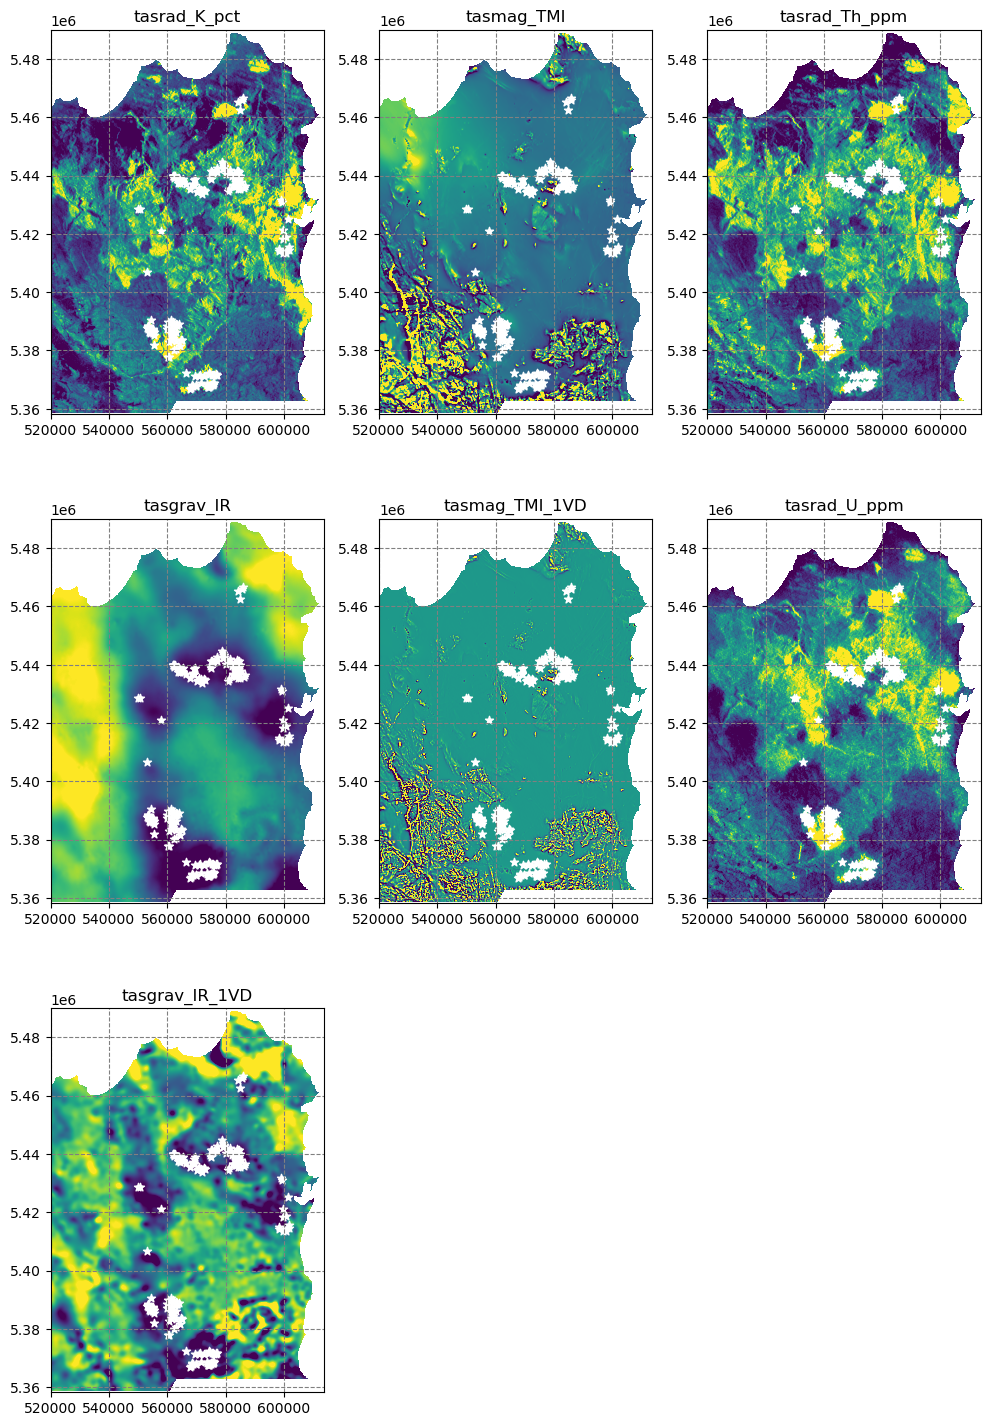

In [10]:
# plot the data
fig, axes = plt.subplots(3,3,figsize=(12,18))
for i, ax in enumerate(axes.flatten()):
    if i < data.shape[0]:
        ax.imshow(data[i], vmin=np.nanpercentile(data[i], 5), vmax=np.nanpercentile(data[i], 95), extent=region)
        ax.set(title=names[i])
        df.plot(ax=ax, marker='*', facecolor='w')
    else:
        ax.axis('off')
plt.show()

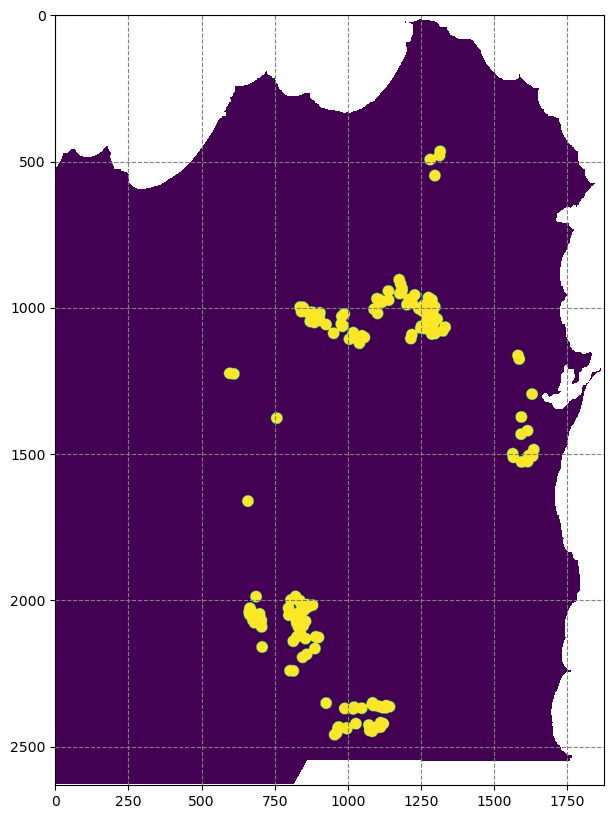

In [11]:
# rasterize the point
geometry_generator = ((geom, 1) for geom in df.buffer(1000).geometry)
labels = rasterize(shapes=geometry_generator, out_shape=data[0].shape, fill=0, transform=transform).astype('float32')
labels[nodata_mask] = np.nan

plt.imshow(labels)

## Data Engineering for UNET's

In [12]:
from typing import Dict, Tuple, Optional, Union, List
import numpy as np
from scipy.interpolate import griddata
from tqdm import tqdm  # For progress tracking

In [13]:
def split_data_by_y_coordinate(data, labels, y_threshold=1800):
    """
    Split data and labels by y-coordinate threshold for train/test split.
    
    Parameters:
    -----------
    data : np.ndarray
        Input data with shape (channels, height, width)
    labels : np.ndarray
        Labels with shape (height, width)
    y_threshold : int
        Y-coordinate threshold for splitting (y ≤ threshold will be training)
        
    Returns:
    --------
    train_data : np.ndarray
        Training data with shape (channels, height_train, width)
    train_labels : np.ndarray
        Training labels with shape (height_train, width)
    test_data : np.ndarray
        Test data with shape (channels, height_test, width)
    test_labels : np.ndarray
        Test labels with shape (height_test, width)
    """
    # Split the data at the y-threshold
    train_data = data[:, :y_threshold, :]  # Takes rows 0-1800
    train_labels = labels[:y_threshold, :]
    
    test_data = data[:, y_threshold:, :]   # Takes rows 1801-2633
    test_labels = labels[y_threshold:, :]
    
    return train_data, train_labels, test_data, test_labels

In [14]:
def extract_and_interpolate_patches_for_pytorch(
    data: np.ndarray,
    labels: np.ndarray,
    patch_size: int = 64,
    stride: int = 16,
    valid_threshold: float = 0.5,
    show_progress: bool = True
) -> Tuple[np.ndarray, np.ndarray, List[Tuple[int, int]]]:
    """
    Extract patches with at least threshold% valid data, interpolate NaN values,
    and return arrays formatted for PyTorch conversion.
    """
    patches_data, patches_labels, patch_indices = [], [], []
    channels, h, w = data.shape
    total_patches = ((h - patch_size + 1) // stride) * ((w - patch_size + 1) // stride)
    valid_patches = 0
    
    # Create reusable coordinate grid for interpolation
    coords = np.stack(np.meshgrid(np.arange(patch_size), np.arange(patch_size), indexing='ij'), axis=-1).reshape(-1, 2)
    
    # Create iterator with optional progress bar
    row_iterator = tqdm(range(0, h - patch_size + 1, stride), desc="Extracting patches") if show_progress else range(0, h - patch_size + 1, stride)
    
    for i in row_iterator:
        for j in range(0, w - patch_size + 1, stride):
            # Extract patch
            patch_data = data[:, i:i+patch_size, j:j+patch_size].copy()
            patch_label = labels[i:i+patch_size, j:j+patch_size].copy()
            
            # Check if patch has enough valid data
            if (1 - np.isnan(patch_label).mean()) >= valid_threshold:
                # Process each channel
                for c in range(channels):
                    channel = patch_data[c]
                    mask = np.isnan(channel)
                    
                    if np.all(mask):
                        # If entire channel is NaN, set to 0
                        channel[mask] = 0
                    elif np.any(mask):
                        # Interpolate NaNs using nearest neighbor
                        points = coords[~mask.ravel()]
                        values = channel[~mask]
                        points_to_interp = coords[mask.ravel()]
                        
                        if len(points) > 0 and len(points_to_interp) > 0:
                            interp_values = griddata(points, values, points_to_interp, method='nearest')
                            channel.flat[np.where(mask.ravel())[0]] = interp_values
                
                # For binary labels, simply fill NaN values with 0
                mask = np.isnan(patch_label)
                if np.any(mask):
                    patch_label[mask] = 0  # Set all NaN values in labels to 0
                
                patches_data.append(patch_data)
                patches_labels.append(patch_label)
                patch_indices.append((i, j))
                valid_patches += 1
    
    # Convert to numpy arrays with proper format for PyTorch
    if patches_data:
        patches_data = np.array(patches_data, dtype=np.float32)
        patches_labels = np.array(patches_labels, dtype=np.float32).reshape(-1, 1, patch_size, patch_size)
    else:
        patches_data = np.empty((0, channels, patch_size, patch_size), dtype=np.float32)
        patches_labels = np.empty((0, 1, patch_size, patch_size), dtype=np.float32)
    
    # Print statistics
    invalid_patches = total_patches - valid_patches
    print(f"Patch Statistics:")
    print(f"  Total patches examined: {total_patches}")
    print(f"  Valid patches (≥{valid_threshold*100}% non-NaN values): {valid_patches} ({valid_patches/total_patches*100:.2f}%)")
    print(f"  Invalid patches (<{valid_threshold*100}% non-NaN values): {invalid_patches} ({invalid_patches/total_patches*100:.2f}%)")
    print(f"  Number of patches exported: {len(patches_data)}")
    
    return patches_data, patches_labels, patch_indices

In [15]:
train_data, train_labels, test_data, test_labels = split_data_by_y_coordinate(data, labels, y_threshold=1800)

In [31]:
stride_size = 36

# Then extract patches from each split separately
print("Processing TRAINING data:")
train_patches_data, train_patches_labels, train_patch_indices = extract_and_interpolate_patches_for_pytorch(
    train_data, train_labels, patch_size=64, stride=stride_size)

print("\nProcessing TEST data:")
test_patches_data, test_patches_labels, test_patch_indices = extract_and_interpolate_patches_for_pytorch(
    test_data, test_labels, patch_size=64, stride=stride_size)

Processing TRAINING data:


Extracting patches: 100%|██████████| 49/49 [00:01<00:00, 47.18it/s]


Patch Statistics:
  Total patches examined: 2400
  Valid patches (≥50.0% non-NaN values): 1972 (82.17%)
  Invalid patches (<50.0% non-NaN values): 428 (17.83%)
  Number of patches exported: 1972

Processing TEST data:


Extracting patches: 100%|██████████| 22/22 [00:00<00:00, 56.42it/s]


Patch Statistics:
  Total patches examined: 1050
  Valid patches (≥50.0% non-NaN values): 1027 (97.81%)
  Invalid patches (<50.0% non-NaN values): 23 (2.19%)
  Number of patches exported: 1027


#### Let's normalize this data

In [32]:
def normalize_channels_for_binary_unet(
    data: np.ndarray,
    calculate_stats: bool = True,
    stats: Optional[Dict[int, Dict[str, float]]] = None,
    show_progress: bool = True
) -> Union[np.ndarray, Tuple[np.ndarray, Dict[int, Dict[str, float]]]]:
    """
    Normalize each channel for binary U-Net classification with vectorized operations.
    
    Parameters:
    -----------
    data : np.ndarray
        Input data with shape (n_patches, channels, patch_height, patch_width)
    calculate_stats : bool, optional
        Whether to calculate statistics (True for training, False for test data)
    stats : Dict[int, Dict[str, float]], optional
        Dictionary with mean/std values (required when calculate_stats is False)
    show_progress : bool, optional
        Whether to display a progress bar during normalization
        
    Returns:
    --------
    normalized_data : np.ndarray
        Data with each channel normalized
    stats : Dict[int, Dict[str, float]], optional
        Dictionary with mean/std values (only returned when calculate_stats is True)
        
    Raises:
    -------
    ValueError
        If stats is None when calculate_stats is False
    """
    # Extract dimensions
    _, n_channels, *_ = data.shape
    print(f"Processing data with {n_channels} channels")
    
    # Validate inputs
    if not calculate_stats and stats is None:
        raise ValueError("Stats must be provided when calculate_stats is False")
    
    # Print statistics for each channel before normalization
    print("\n--- Channel Statistics Before Normalization ---")
    for c in range(n_channels):
        channel_data = data[:, c].flatten()
        channel_min = np.nanmin(channel_data)
        channel_max = np.nanmax(channel_data)
        channel_mean = np.nanmean(channel_data)
        channel_median = np.nanmedian(channel_data)
        print(f"Channel {c}: min={channel_min:.3f}, max={channel_max:.3f}, mean={channel_mean:.3f}, median={channel_median:.3f}")
    
    # Preallocate output array with same shape and float32 type
    normalized_data = np.zeros_like(data, dtype=np.float32)
    
    if calculate_stats:
        # Fully vectorized approach for computing stats
        # Reshape data for easy channel-wise operations (n_channels, n_patches*height*width)
        reshaped_data = data.transpose(1, 0, 2, 3).reshape(n_channels, -1)
        
        # Compute mean and std for all channels at once
        means = np.nanmean(reshaped_data, axis=1)
        stds = np.nanstd(reshaped_data, axis=1)
        
        # Replace zero stds with 1.0 to avoid division by zero
        stds = np.maximum(stds, 1.0)
        
        # Build stats dictionary with progress indicator if requested
        computed_stats: Dict[int, Dict[str, float]] = {}
        iterator = tqdm(range(n_channels), desc="Building stats") if show_progress else range(n_channels)
        for c in iterator:
            computed_stats[c] = {'mean': float(means[c]), 'std': float(stds[c])}
        
        # Vectorized normalization for all channels
        for c in tqdm(range(n_channels), desc="Normalizing") if show_progress else range(n_channels):
            normalized_data[:, c] = (data[:, c] - means[c]) / stds[c]
        
    else:
        # Apply pre-computed statistics (still need loop, but only for lookup)
        assert stats is not None  # For type checker
        
        # Extract means and stds for vectorized operations
        means = np.array([stats[c]['mean'] for c in range(n_channels)])
        stds = np.array([stats[c]['std'] for c in range(n_channels)])
        
        # Normalize each channel in a loop
        for c in tqdm(range(n_channels), desc="Normalizing") if show_progress else range(n_channels):
            normalized_data[:, c] = (data[:, c] - means[c]) / stds[c]
    
    # Print statistics for each channel after normalization
    print("\n--- Channel Statistics After Normalization ---")
    for c in range(n_channels):
        channel_data = normalized_data[:, c].flatten()
        channel_min = np.nanmin(channel_data)
        channel_max = np.nanmax(channel_data)
        channel_mean = np.nanmean(channel_data)
        channel_median = np.nanmedian(channel_data)
        print(f"Channel {c}: min={channel_min:.3f}, max={channel_max:.3f}, mean={channel_mean:.3f}, median={channel_median:.3f}")
    
    print(f"Final normalized data shape: {normalized_data.shape}")
    return (normalized_data, computed_stats) if calculate_stats else normalized_data

In [33]:
# Normalize training data and get statistics
train_patches_normalized, norm_stats = normalize_channels_for_binary_unet(train_patches_data, calculate_stats=True)

print("\nProcessing TEST data:")
# Apply same normalization to test data
test_patches_normalized = normalize_channels_for_binary_unet(
    test_patches_data, 
    calculate_stats=False, 
    stats=norm_stats
)

# Make sure labels are binary (0 or 1)
train_patches_labels = (train_patches_labels > 0).astype(np.float32)
test_patches_labels = (test_patches_labels > 0).astype(np.float32)

Processing data with 7 channels

--- Channel Statistics Before Normalization ---
Channel 0: min=-0.563, max=4.176, mean=0.870, median=0.776
Channel 1: min=-2362.806, max=4588.527, mean=-28.806, median=-44.431
Channel 2: min=-0.426, max=43.514, mean=7.467, median=7.472
Channel 3: min=-525.749, max=2294.860, mean=-155.002, median=-158.838
Channel 4: min=-21.784, max=50.318, mean=-0.001, median=-0.003
Channel 5: min=-0.709, max=9.821, mean=1.589, median=1.543
Channel 6: min=-49847.531, max=336924.656, mean=-19.264, median=46.411


Normalizing: 100%|██████████| 7/7 [00:00<00:00, 154.88it/s]



--- Channel Statistics After Normalization ---
Channel 0: min=-1.433, max=3.307, mean=-0.000, median=-0.094
Channel 1: min=-28.252, max=55.890, mean=0.000, median=-0.189
Channel 2: min=-2.302, max=10.516, mean=-0.000, median=0.002
Channel 3: min=-5.397, max=35.661, mean=0.000, median=-0.056
Channel 4: min=-21.783, max=50.319, mean=0.000, median=-0.002
Channel 5: min=-2.298, max=8.231, mean=-0.000, median=-0.047
Channel 6: min=-51.059, max=345.268, mean=0.000, median=0.067
Final normalized data shape: (1972, 7, 64, 64)

Processing TEST data:
Processing data with 7 channels

--- Channel Statistics Before Normalization ---
Channel 0: min=-0.148, max=4.737, mean=0.782, median=0.694
Channel 1: min=-2104.979, max=4813.387, mean=-19.266, median=-57.934
Channel 2: min=-1.843, max=59.127, mean=6.514, median=5.793
Channel 3: min=-359.978, max=-22.598, mean=-180.692, median=-174.465
Channel 4: min=-20.849, max=38.208, mean=-0.006, median=-0.010
Channel 5: min=-0.690, max=13.529, mean=1.276, medi

Normalizing: 100%|██████████| 7/7 [00:00<00:00, 127.21it/s]


--- Channel Statistics After Normalization ---
Channel 0: min=-1.018, max=3.868, mean=-0.088, median=-0.175
Channel 1: min=-25.131, max=58.612, mean=0.115, median=-0.353
Channel 2: min=-2.716, max=15.071, mean=-0.278, median=-0.488
Channel 3: min=-2.984, max=1.927, mean=-0.374, median=-0.283
Channel 4: min=-20.848, max=38.208, mean=-0.005, median=-0.009


Channel 5: min=-2.279, max=11.940, mean=-0.314, median=-0.490
Channel 6: min=-4.941, max=4.420, mean=-0.114, median=0.086
Final normalized data shape: (1027, 7, 64, 64)


## Train Models

In [34]:
cpus = os.cpu_count()
print(f'The number of available CPUs is: {cpus}')

The number of available CPUs is: 12


In [35]:
# Import the UNet model
from unet_model import UNet, train_model, predict

In [36]:
# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [37]:
# Set number of CPU threads
num_workers = min(12, os.cpu_count()-1)
torch.set_num_threads(num_workers)
print(f"Using {num_workers} CPU threads for PyTorch")

Using 11 CPU threads for PyTorch


In [38]:
# Enable performance optimizations
torch.backends.cudnn.benchmark = True  # Optimize for fixed input sizes (even on CPU this can help)

In [39]:
# Convert numpy arrays to PyTorch tensors
train_patches_normalized = torch.tensor(train_patches_normalized, dtype=torch.float32)
train_patches_labels = torch.tensor(train_patches_labels, dtype=torch.float32)
test_patches_normalized = torch.tensor(test_patches_normalized, dtype=torch.float32)
test_patches_labels = torch.tensor(test_patches_labels, dtype=torch.float32)

# Check shapes - add channel dimension to labels if needed
print(f"Train data shape: {train_patches_normalized.shape}")
print(f"Train labels shape: {train_patches_labels.shape}")

# Now create your datasets
train_dataset = TensorDataset(train_patches_normalized, train_patches_labels)
test_dataset = TensorDataset(test_patches_normalized, test_patches_labels)

Train data shape: torch.Size([1972, 7, 64, 64])
Train labels shape: torch.Size([1972, 1, 64, 64])


In [40]:
batch_size = 64  # Increased batch size for CPU training
num_workers = min(6, os.cpu_count() // 2)  # Use half the cores for data loading

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

# Create the UNet model
model = UNet(in_channels=7)

In [42]:
# Create modified UNet with CPU optimizations (optional)
class UNetCPUOptimized(UNet):
    """UNet with CPU-specific optimizations"""
    def __init__(self, in_channels=7, bilinear=False):
        super().__init__(in_channels, bilinear)
        
        # Optional: Replace BatchNorm with GroupNorm which can be more efficient on CPU
        self.replace_batchnorm_with_groupnorm()
        
    def replace_batchnorm_with_groupnorm(self):
        """Replace BatchNorm2d with GroupNorm for potential CPU speedup"""
        for name, module in self.named_modules():
            if isinstance(module, nn.BatchNorm2d):
                # Get parent module
                parent_name = name.rsplit('.', 1)[0] if '.' in name else ''
                parent = self if parent_name == '' else getattr(self, parent_name)
                
                # Get the module name in its parent
                child_name = name.rsplit('.', 1)[1] if '.' in name else name
                
                # Replace with GroupNorm (num_groups=8 is usually a good default)
                num_channels = module.num_features
                num_groups = min(8, num_channels)
                setattr(parent, child_name, nn.GroupNorm(num_groups, num_channels))
        
        return self

In [43]:
# Choose whether to use CPU optimized model
use_cpu_optimized = False  # Set to True to use optimized model

if use_cpu_optimized and device.type == 'cpu':
    model = UNetCPUOptimized(in_channels=7)
    print("Using CPU-optimized UNet model")
else:
    model = UNet(in_channels=7)
    print("Using standard UNet model")

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define a learning rate scheduler (optional)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

Using standard UNet model


In [47]:
def train_model_with_validation(model, train_loader, test_loader, criterion, optimizer, scheduler, device, num_epochs=10):
    model.to(device)
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}
    
    # Print training setup information
    print("\n" + "="*80)
    print(f"Starting training with:")
    print(f"- Loss function: {criterion.__class__.__name__}")
    print(f"- Optimizer: {optimizer.__class__.__name__} (lr={optimizer.param_groups[0]['lr']})")
    print(f"- Scheduler: {scheduler.__class__.__name__}")
    print(f"- Device: {device}")
    print(f"- Epochs: {num_epochs}")
    print(f"- Training samples: {len(train_loader.dataset)}")
    print(f"- Validation samples: {len(test_loader.dataset)}")
    print(f"- Batch size: {train_loader.batch_size}")
    print("="*80 + "\n")
    
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        train_loss = 0.0
        
        # Progress bar for this epoch's training batches
        train_bar = tqdm(train_loader, desc=f"Training", 
                         leave=True, total=len(train_loader))
        
        for inputs, labels in train_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad(set_to_none=True)
            
            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimize
            loss.backward()
            optimizer.step()
            
            # Update statistics
            batch_loss = loss.item()
            train_loss += batch_loss * inputs.size(0)
            
            # Update progress bar
            train_bar.set_postfix({"loss": f"{batch_loss:.4f}"})
        
        train_loss = train_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        
        # Progress bar for this epoch's validation batches
        val_bar = tqdm(test_loader, desc=f"Validation", 
                       leave=True, total=len(test_loader))
        
        with torch.no_grad():
            for inputs, labels in val_bar:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                batch_loss = criterion(outputs, labels).item()
                val_loss += batch_loss * inputs.size(0)
                
                # Update progress bar
                val_bar.set_postfix({"loss": f"{batch_loss:.4f}"})
        
        val_loss = val_loss / len(test_loader.dataset)
        history['val_loss'].append(val_loss)
        
        # Update the learning rate
        scheduler.step(val_loss)
        
        # Save the best model
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_unet_model.pth')
            save_msg = "✓ Saved new best model"
        else:
            save_msg = ""
        
        # Print epoch statistics
        if save_msg:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f} - {save_msg}")
        else:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
        
        # Print a separator between epochs
        print("-" * 80)
    
    # Load the best model
    model.load_state_dict(torch.load('best_unet_model.pth'))
    return model, history

In [ ]:
# Train the model
model, history = train_model_with_validation(
    model, 
    train_loader, 
    test_loader, 
    criterion, 
    optimizer, 
    scheduler, 
    device, 
    num_epochs=15
)


Starting training with:
- Loss function: BCELoss
- Optimizer: Adam (lr=0.001)
- Scheduler: ReduceLROnPlateau
- Device: cpu
- Epochs: 15
- Training samples: 1972
- Validation samples: 1027
- Batch size: 64

Epoch 1/15


Validation: 100%|██████████| 17/17 [00:21<00:00,  1.24s/it, loss=0.1853]


Epoch 1/15 - Train Loss: 0.2621, Val Loss: 0.2394 - ✓ Saved new best model
--------------------------------------------------------------------------------
Epoch 2/15


Training:  23%|██▎       | 7/31 [00:29<01:39,  4.16s/it, loss=0.1809]